In [98]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from statistics import mode
import math
%matplotlib inline


In [99]:
matches = pd.read_csv('matches.csv')
delivery = pd.read_csv('deliveries.csv')
match_ids = matches[matches.season >= 2016]['id'].unique()
matches1 = matches[(matches.season >= 2016) & (matches['result']=='normal')]
matches1 = matches1.drop(['player_of_match','venue','umpire1','umpire2','umpire3', 'dl_applied', 'city', 'date', 'result'], axis=1)
matches1.dropna(inplace=True)

In [100]:
def team_correction(row):
    row = row.strip()
    if row == 'Delhi Daredevils':
        return 'Delhi Capitals'
    if row == 'Rising Pune Supergiants':
        return 'Rising Pune Supergiant'
    return row

for col in ['team1', 'team2', 'winner', 'toss_winner']:
    matches1[col] = matches1[col].apply(team_correction)
    

In [101]:
team_1 = 'Delhi Capitals'
team_2 = 'Mumbai Indians'

In [102]:
delivery = delivery[delivery.match_id.apply(lambda x: True if x in match_ids else False)]
for col in ['batting_team', 'bowling_team']:
    delivery[col] = delivery[col].apply(team_correction)

delivery.fillna(0, inplace=True)
delivery['player_dismissed'] = delivery['player_dismissed'].apply(lambda x: 0 if x==0 else 1)

delivery['batsman_runs'] = delivery['batsman_runs'].apply(lambda x: x-1 if ((x==7) or (x==5)) else x)

In [103]:
def clean(row):
    if row['extra_runs']>= row['batsman_runs']:
        row['extra_runs'] -= row['batsman_runs']
        
    return row

delivery = delivery.apply(clean, axis=1)
delivery['total_runs'] = delivery['extra_runs'] + delivery['batsman_runs']

# Winning Probability of Teams

Text(0.5, 1.0, 'MI Total Runs Score Stats Per Count')

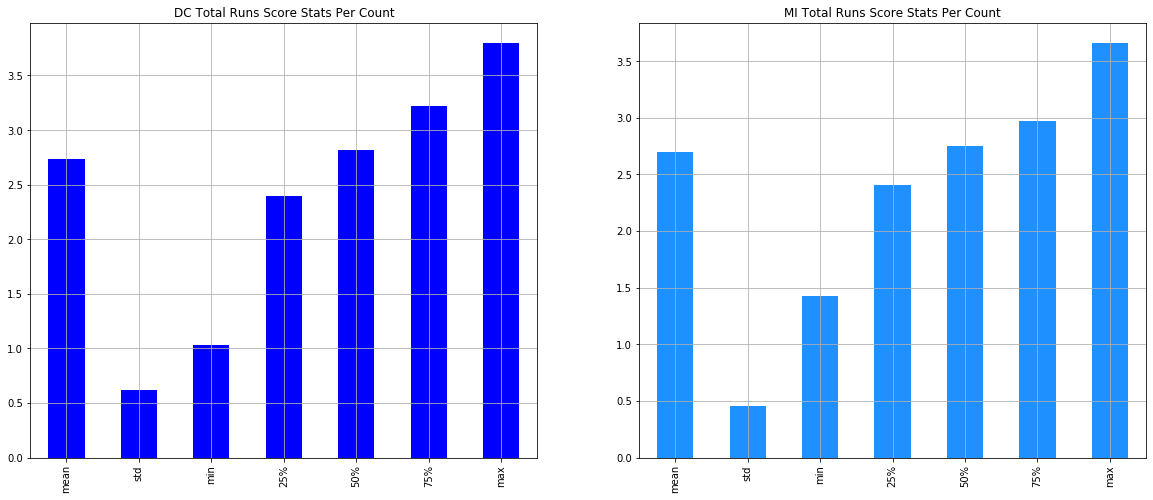

In [104]:
fig, ax = plt.subplots(1,2, figsize=(20,8))
dc_runs = delivery[delivery['batting_team']==team_1].groupby('match_id').sum()['total_runs']
mi_runs = delivery[delivery['batting_team']==team_2].groupby('match_id').sum()['total_runs']
(dc_runs.describe()[1:]/dc_runs.describe()[0]).plot(ax=ax[0], kind='bar', grid=True, color='blue')
(mi_runs.describe()[1:]/mi_runs.describe()[0]).plot(ax=ax[1], kind='bar', grid=True, color='dodgerblue')
ax[0].set_title("DC Total Runs Score Stats Per Count")
ax[1].set_title("MI Total Runs Score Stats Per Count")

Text(0.5, 1.0, 'Percentage of Winning')

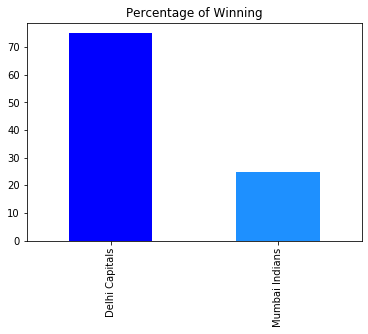

In [105]:
wins = pd.DataFrame(matches1[(matches1['team1'].isin([team_1, team_2])) & (matches1['team2'].isin([team_1, team_2])) & (matches1['season']>=2018)]['winner'].value_counts())
wins['Percentage Win Chance'] = (wins['winner']/sum(wins['winner']))*100
wins['Percentage Win Chance'].plot(kind='bar', color=['blue', 'dodgerblue'])
plt.title('Percentage of Winning')

# Wickets Fall

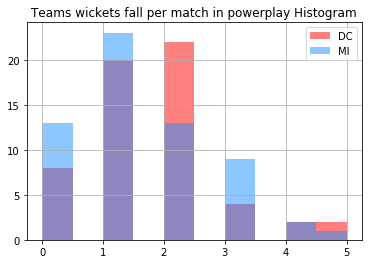

In [106]:
delivery[(delivery['batting_team']==team_1) & (delivery['over']<=6)].groupby('match_id').sum()['player_dismissed'].hist(alpha=0.5, color='red', label='DC')
delivery[(delivery['batting_team']==team_2) & (delivery['over']<=6)].groupby('match_id').sum()['player_dismissed'].hist(alpha=0.5, color='dodgerblue', label='MI')
plt.title("Teams wickets fall per match in powerplay Histogram")
plt.legend()

DC has lost 2 wickets most of the times and MI ha slost 1. So, total wickets fall will lie in range in 2-3.

# Economy Rate

In [107]:
def economy_rate(bowler):
    rates = list()
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        
        match = delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id)]
        b_4s = len(match[(match['total_runs'].isin([4, 5]))])
        b_6s = len(match[(match['total_runs'].isin([6, 7]))])
        t_runs = sum(match['total_runs'])
        total_b = b_4s + b_6s
        balls = len(match)
        
        if (balls/6 > 1):
            rate = t_runs*6/balls
            rates.append([bowler, t_runs, balls, b_4s, b_6s, total_b, round(rate, 2)])
        
    return rates

In [108]:
mi_team = ['Q de Kock', 'SA Yadav', 'RG Sharma', 'Ishan Kishan', 'KH Pandya', 'HH Pandya', 'KA Pollard', 'JL Pattinson', 'TA Boult', 'RD Chahar', 'JJ Bumrah']
dc_team = ['PP Shaw', 'S Dhawan','SS Iyer', 'RR Pant' ,'SO Hetmyer','A Nortje', 'TU Deshpande', 'K Rabada', 'R Ashwin', 'AR Patel', 'MP Stoinis']

In [109]:
bowlers_performance = list()
for player in (mi_team+dc_team):
    bowlers_performance += (economy_rate(player))

bowlers_performance_df = pd.DataFrame(data=bowlers_performance, columns=['Bowler', 'Runs', 'Balls', '4s', '6s', 'Boundaries', 'ER'])
bowlers_performance_df.head()

,Bowler,Runs,Balls,4s,6s,Boundaries,ER
0,KH Pandya,21,12,1,1,2,10.50
1,KH Pandya,24,24,2,0,2,6.00
2,KH Pandya,11,8,1,0,1,8.25
3,KH Pandya,25,24,2,0,2,6.25
4,KH Pandya,18,18,1,0,1,6.00


In [110]:
bowlers_performance_df.groupby('Bowler').mean().sort_values(by='ER')

,Runs,Balls,4s,6s,Boundaries,ER
Bowler,,,,,,
RD Chahar,25.500000,23.357143,1.642857,1.214286,2.857143,6.531429
JJ Bumrah,28.406780,23.779661,2.457627,0.745763,3.203390,7.113898
KH Pandya,22.632653,19.265306,1.612245,0.632653,2.244898,7.307755
R Ashwin,28.538462,23.512821,1.641026,1.051282,2.692308,7.393590
AR Patel,27.367347,21.367347,1.653061,1.204082,2.857143,7.816735
K Rabada,32.222222,24.111111,3.500000,0.833333,4.333333,8.023333
HH Pandya,26.073171,18.121951,2.219512,1.219512,3.439024,8.559268
TA Boult,34.615385,23.884615,3.807692,1.230769,5.038462,8.719231
MP Stoinis,26.428571,17.142857,2.428571,1.095238,3.523810,9.590952


Bowlers with economy rate not greater than 8 was considered because the bowlers with economy rate greater than 8 have higher chances of having rate greater than 9 in today's match. 

# Batsmen Score

In [111]:
def batsman_score(batsman):
    runs = list()
    for match_id in delivery[(delivery['batsman']==batsman)]['match_id'].unique():
        
        match = delivery[(delivery['batsman']==batsman) & (delivery['match_id']==match_id)]
        run = sum(match['batsman_runs'])
        runs.append([batsman, run])
        
    return runs

In [112]:
batsman_runs = list()
for player in (mi_team+dc_team):
    batsman_runs += (batsman_score(player))

batsman_runs_df = pd.DataFrame(data=batsman_runs, columns=['Batsman', 'Runs per match'])
batsman_runs_df.head()

,Batsman,Runs per match
0,Q de Kock,16
1,Q de Kock,59
2,Q de Kock,108
3,Q de Kock,9
4,Q de Kock,5


In [117]:
batsman_runs_df.groupby('Batsman').mean().sort_values(by='Runs per match', ascending=False).head(5)

,Runs per match
Batsman,
RR Pant,33.148148
Q de Kock,32.621622
S Dhawan,32.523810
SS Iyer,27.106383
RG Sharma,25.881356


# Jasprit Bumrah Death Over Economy Rate

In [114]:
def mean_economy_rate_death_over(bowler):
    rates = list()
    for match_id in delivery[(delivery['bowler']==bowler)]['match_id'].unique():
        
        match = delivery[(delivery['bowler']==bowler) & (delivery['match_id']==match_id) & (delivery['over']>=15)]
        t_runs = sum(match['total_runs'])
        balls = len(match)
        
        if (balls > 0):
            rate = t_runs*6/balls
            rates.append(round(rate, 2))
        
    print("Mean ER:", np.mean(rates))
    print("Min ER:", np.min(rates))
    print("Max ER", np.max(rates))
    print("Median ER", np.median(rates))
    

In [115]:
mean_economy_rate_death_over('JJ Bumrah')

Mean ER: 8.276140350877194
Min ER: 2.77
Max ER 15.5
Median ER 8.0


# Summary

1. Using data of 2018, 2019, the chances of winning using winner column was taken out for both the teams.
2. Wickets falls for both the teams per match in powerplay using player_dismissed column and plotting histogram, the frequency peak of both the teams were summed to find the range.
3. A function to calculate economy rate of bowlers was created. No. of 4s, 6s, total runs given, total balls were calculated using total_runs column. A dataframe was created using this data for every bowler for each of his matches, and mean values were calculated per bowler and range was estimated.
4. A function to calculate batsman run in a match was calculated by using batsman_run column by filtering data for that particular batsman. Then, the mean scores were calculated and range was estimated.
5. A function to calculate mean economy rate in death overs of a bowler was created. The function filters data for a bowler per match and finds economy rate using for only death overs and returns mean value.